In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import sklearn


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, LSTM, Input,SpatialDropout1D, GlobalMaxPool1D, MaxPooling1D, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_score, accuracy_score, recall_score, f1_score
from tensorflow.keras.optimizers import Adam

In [2]:
# 5. Membaca file CSV ke dalam DataFrame
import pandas as pd
df = pd.read_csv('dataset_50k.csv')
df.head()

Unnamed: 0  Label                                         detokenize
0           0      1  aku luka diri aku jalan hidup sulit orang tua ...
1           1      0   buang pikir negatif laku gelisah milik putus asa
2           2      1  jujur aku takut mati aku orang aku sulit paham...
3           3      0              saya mes pasang sepatu jam saya harap
4           4      1  capek hati banget aku allah aku kayak mata ora...

In [3]:
df = df.dropna()
df

Unnamed: 0  Label                                         detokenize
0               0      1  aku luka diri aku jalan hidup sulit orang tua ...
1               1      0   buang pikir negatif laku gelisah milik putus asa
2               2      1  jujur aku takut mati aku orang aku sulit paham...
3               3      0              saya mes pasang sepatu jam saya harap
4               4      1  capek hati banget aku allah aku kayak mata ora...
...           ...    ...                                                ...
50518       50518      0  curi rampok liar begal rakyat senantiasa resah...
50519       50519      0                      saya bicara saya buat tertawa
50520       50520      1  sakit sakit guna sakit bahagia sakit bohong or...
50521       50521      1                              lantai lantai gelisah
50522       50522      1  aku tulis catat kemarin kata tunang aku laku b...

[50523 rows x 3 columns]

In [4]:
df['label'] = df['Label'].apply(lambda x: 0 if x == 0 else 1)
df.head()

Unnamed: 0  Label                                         detokenize  label
0           0      1  aku luka diri aku jalan hidup sulit orang tua ...      1
1           1      0   buang pikir negatif laku gelisah milik putus asa      0
2           2      1  jujur aku takut mati aku orang aku sulit paham...      1
3           3      0              saya mes pasang sepatu jam saya harap      0
4           4      1  capek hati banget aku allah aku kayak mata ora...      1

<BarContainer object of 2 artists>

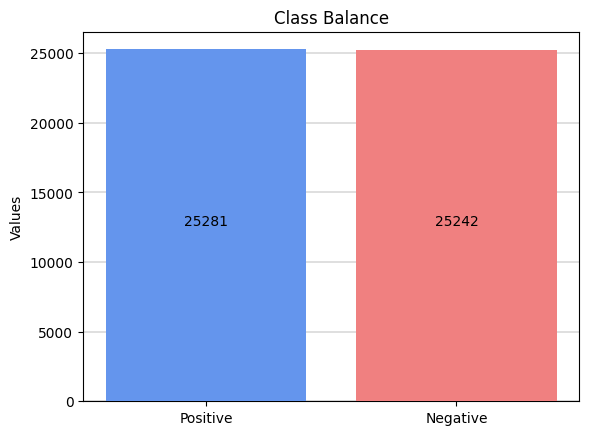

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center',zorder=4)

# Count the values in the 'Label' column
count = df['Label'].value_counts()
x = ["Positive", "Negative"]  # Custom labels for class balance plot
y = [count[1], count[0]]
addlabels(x,y)
plt.ylabel("Values")
plt.title('Class Balance')
plt.grid(color='dimgray', linewidth=0.3, axis='y',zorder=0)
plt.bar(x,y, color= ['cornflowerblue', 'lightcoral'], zorder=3)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vektorisasi teks menggunakan TF-IDF bigram)
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(2,2), max_df=0.7, max_features=10000)

# Menggunakan fit_transform untuk mengubah dokumen menjadi fitur
vector = vectorizer.fit_transform(df['detokenize']).toarray()
tf_idf_len = len(vectorizer.vocabulary_)

In [7]:
#Split data 80% data train and 20% data test
x_unigram = pd.DataFrame(vector)
label = df["Label"]
x_train, x_test, y_train, y_test =  model_selection.train_test_split(x_unigram,label, test_size = 0.1)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(45470, 10000) (45470,)
(5053, 10000) (5053,)


In [8]:
y_train

28862    1
16581    1
21715    1
25969    1
19653    1
        ..
4339     1
5110     1
2603     1
39178    1
47338    0
Name: Label, Length: 45470, dtype: int64

In [9]:
x_train = np.array(x_train).reshape(-1, 1, x_train.shape[1])
x_test = np.array(x_test).reshape(-1, 1, x_test.shape[1])

In [10]:
x_train

array([[[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]]])

In [11]:
x_train.shape

(45470, 1, 10000)

In [12]:
import matplotlib.pyplot as plt

def make_plot(history, train, validation, title):
    graph = plt.plot(history.history[train], lw=2.0)
    graph = plt.plot(history.history[validation], lw=2.0)
    graph = plt.title(title)
    graph = plt.legend(['training', 'validasi'])
    graph = plt.show()

    return graph

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Membuat model hybrid lstm-cnn
def hybrid_lstm_cnn(x_train, y_train, x_test, y_test):


    model = Sequential()
    model.add(Input(shape=(1,x_train.shape[2])))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',optimizer=optimizer ,metrics=['accuracy'])
    print(model.summary())

    history = model.fit(x_train, y_train, epochs = 10, validation_data=(x_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)] )

    #Membuat plot garis akurasi
    make_plot(history, "accuracy", "val_accuracy", "Perubahan Akurasi tiap epoch")

    #predict
    predictions = model.predict(x_test)
    print()
    print("Classification Report :")
    print(classification_report(y_test, predictions.round(), digits=6))


    acc_score = accuracy_score(y_test, predictions.round())
    prec_score = precision_score(y_test, predictions.round())
    rec_score = recall_score(y_test, predictions.round())
    f1score = f1_score(y_test, predictions.round())

    return [acc_score,prec_score,rec_score,f1score ]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ spatial_dropout1d (SpatialDropout1D) │ (None, 1, 10000)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1, 128)              │       5,186,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 1, 128)              │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,272,257 (20.11 MB)

 Trainable params: 5,272,257 (20.11 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.7075 - loss: 0.5266 - val_accuracy: 0.7922 - val_loss: 0.4034
Epoch 2/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.8001 - loss: 0.3825 - val_accuracy: 0.7894 - val_loss: 0.4038
Epoch 3/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.8136 - loss: 0.3616 - val_accuracy: 0.7875 - val_loss: 0.4127
Epoch 4/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.8180 - loss: 0.3458 - val_accuracy: 0.7880 - val_loss: 0.4199


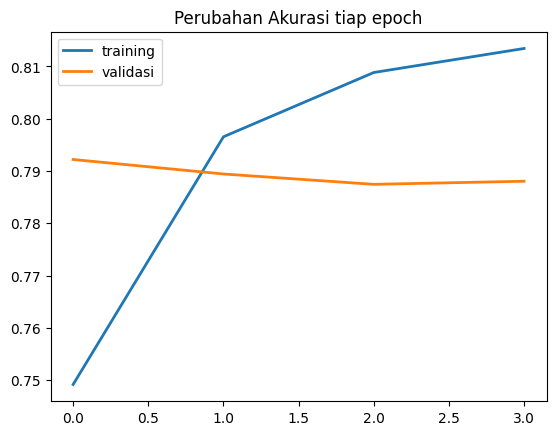

158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.782823  0.806313  0.794394      2566
           1   0.793776  0.769200  0.781295      2487

    accuracy                       0.788047      5053
   macro avg   0.788299  0.787757  0.787844      5053
weighted avg   0.788214  0.788047  0.787947      5053



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ spatial_dropout1d_1                  │ (None, 1, 10000)            │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1, 128)              │       5,186,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 1, 128)              │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,272,257 (20.11 MB)

 Trainable params: 5,272,257 (20.11 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.7073 - loss: 0.5259 - val_accuracy: 0.7958 - val_loss: 0.3997
Epoch 2/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.8013 - loss: 0.3852 - val_accuracy: 0.7910 - val_loss: 0.4074
Epoch 3/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.8140 - loss: 0.3582 - val_accuracy: 0.7849 - val_loss: 0.4108
Epoch 4/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.8184 - loss: 0.3479 - val_accuracy: 0.7896 - val_loss: 0.4112


158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.811438  0.763055  0.786503      2566
           1   0.769697  0.817049  0.792666      2487

    accuracy                       0.789630      5053
   macro avg   0.790568  0.790052  0.789585      5053
weighted avg   0.790894  0.789630  0.789537      5053



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ spatial_dropout1d_2                  │ (None, 1, 10000)            │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 1, 128)              │       5,186,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 1, 128)              │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,272,257 (20.11 MB)

 Trainable params: 5,272,257 (20.11 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.7073 - loss: 0.5247 - val_accuracy: 0.7880 - val_loss: 0.4066
Epoch 2/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.8016 - loss: 0.3834 - val_accuracy: 0.7902 - val_loss: 0.4062
Epoch 3/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.8096 - loss: 0.3579 - val_accuracy: 0.7886 - val_loss: 0.4100
Epoch 4/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.8196 - loss: 0.3479 - val_accuracy: 0.7859 - val_loss: 0.4190
Epoch 5/10
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.8207 - loss: 0.3429 - val_accuracy: 0.7863 - val_loss: 0.4305


158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Classification Report :
              precision    recall  f1-score   support

           0   0.806013  0.762666  0.783740      2566
           1   0.768000  0.810615  0.788732      2487

    accuracy                       0.786266      5053
   macro avg   0.787007  0.786640  0.786236      5053
weighted avg   0.787304  0.786266  0.786197      5053



In [14]:
result = []
result.append(hybrid_lstm_cnn(x_train, y_train, x_test, y_test))
result.append(hybrid_lstm_cnn(x_train, y_train, x_test, y_test))
result.append(hybrid_lstm_cnn(x_train, y_train, x_test, y_test))

In [15]:
average = np.mean(result, axis=0, dtype=float)
print('Average Accuracy  :', average[0])
print('Average Precision :', average[1])
print('Average Recall    :', average[2])
print('Average F1-Score  :', average[3])

Average Accuracy  : 0.7879807375156672
Average Precision : 0.7771576344356427
Average Recall    : 0.7989545637314034
Average F1-Score  : 0.7875644470491471
